# Utilities and imports

In [2]:
from maxentnuc.analysis.domain_analyzer import DomainAnalyzer, get_boundary_loops, Domains
from maxentnuc.analysis.mei_analyzer import MEIAnalyzer
from maxentnuc.analysis.analysis import *
from maxentnuc.analysis.insulation import *

from matplotlib.colors import LogNorm
import os
from cooltools.api.insulation import _insul_diamond_dense
from neighbor_balance.plotting import parse_region, format_ticks, ContactMap, apply_matplotlib_style, load_bw, bin_track

omics = '/home/joepaggi/orcd/pool/omics'
mei_runs = '/orcd/data/binz/001/joepaggi/mei_runs'

apply_matplotlib_style()

In [2]:
prod = {
    '35 nm': {'config': f'{mei_runs}/nanog/v47/config.yaml', 'scale': 1/10, 'iteration': 15},
    '42 nm': {'config': f'{mei_runs}/nanog/v36/config.yaml', 'scale': 1/10, 'iteration': 18},
    '50 nm': {'config': f'{mei_runs}/nanog/v46/config.yaml', 'scale': 1/10, 'iteration': 15},
    '1/21': {'config': f'{mei_runs}/nanog/v48/config.yaml', 'scale': 1/10, 'iteration': 19},
    '4/21': {'config': f'{mei_runs}/nanog/v49/config.yaml', 'scale': 1/10, 'iteration': 18},
}

for name in prod:
    prod[name]['mei'] = MEIAnalyzer(prod[name]['config'], scale=0.1)

main_names = list(prod.keys())

In [3]:
analyzer = DomainAnalyzer(30, 200, min_loop_size=2, add_boundary_linkers=True)
analyzer.min_samples, to_micromolar(analyzer.min_samples, 4/3*np.pi*30**3)

(14, 205.5582496850931)

In [4]:
domains = {}
for name, info in prod.items():
    print(name)
    trajectory = info['mei'].get_positions(info['iteration'], skip=11, burnin=0)
    trajectory = trajectory.reshape(-1, *trajectory.shape[-2:])
    domains[name] = analyzer.analyze_trajectory(trajectory)

35 nm


/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
INFO:MDAnalysis.core.universe:The attribute(s) masses, types have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not

42 nm


INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not guess any new values for masses attribute
INFO:MDAnalysis.core.universe:The attribute(s) masses, types have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not guess any new values for masses attribute


50 nm


/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
INFO:MDAnalysis.core.universe:The attribute(s) masses, types have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not

1/21


INFO:MDAnalysis.core.universe:The attribute(s) masses, types have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not guess any new values for masses attribute
/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDRea

4/21


INFO:MDAnalysis.core.universe:The attribute(s) masses, types have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not guess any new values for masses attribute


35 nm 0.022857142857142857
42 nm 0.16095238095238096
50 nm 0.2938095238095238
1/21 0.14857142857142858
4/21 0.1361904761904762


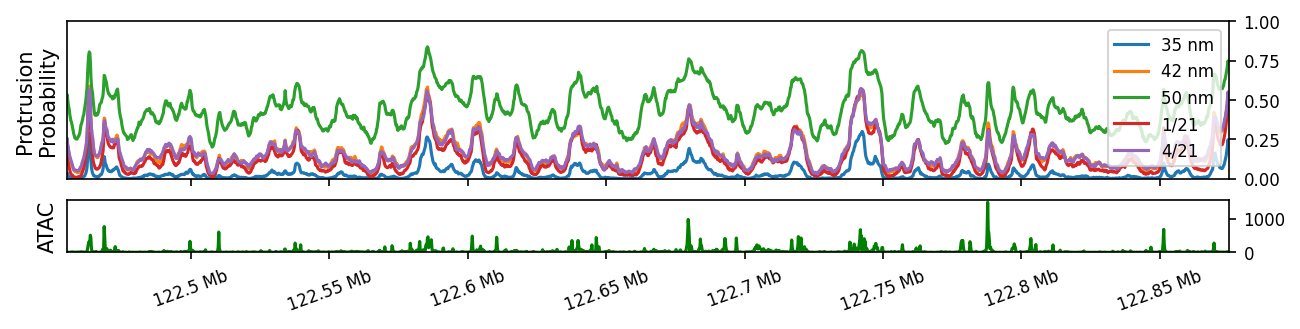

In [5]:
def get_loops(labels):
    loops = []
    loop_start = None
    for i in range(len(labels)):
        if labels[i] == -1:
            if loop_start is None:
                loop_start = i
        elif loop_start is not None:
            loops += [(loop_start, i)]
            loop_start = None
    if loop_start is not None:
        loops += [(loop_start, len(labels))]
    return loops

def get_boundary_loops(labels):
    loops = get_loops(labels)
    print(loops)

    boundary_loops = []
    for start, end in loops:
        if start == 0:
            continue
        if end == len(labels) - 1:
            continue

        if labels[start - 1] != labels[end]:
            boundary_loops += [(start, end)]

    mask = labels[1:] != labels[:-1]
    mask &= labels[1:] != -1
    mask &= labels[:-1] != -1
    no_loops = np.arange(len(mask))[mask]
    for s in no_loops:
        boundary_loops += [(s, s+1)]
    return boundary_loops


region = prod['42 nm']['mei'].mei.config['region']
chrom, start, end = parse_region(region)

f, ax = plt.subplots(2, figsize=(10, 2), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
x = np.arange(start, end, 200)
atac = f'{omics}/genomics_data/GSE98390_E14_ATAC_MERGED.DANPOS.mm39.bw'
atac = load_bw(atac, chrom, start, end)
atac = bin_track(atac, step=200)
ax[1].plot(x, atac, c='green')

buff = 50_000 // 200
metrics = {}
for name in prod:
    region = prod[name]['mei'].mei.config['region']
    chrom, start, end = parse_region(region)
    print(name, np.mean(domains[name][0].labels == -1))
    loop = np.array([d.labels == -1 for d in domains[name]]).astype(bool)

    ax[0].plot(x, np.mean(loop, axis=0), label=name)

    metrics[name] = {}
    metrics[name]['loop'] = np.mean(loop[:, buff:-buff])

ax[0].legend()
ax[0].set_ylabel('Protrusion\nProbability')
ax[1].set_ylabel('ATAC')
ax[0].yaxis.tick_right()
ax[1].yaxis.tick_right()
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0)
ax[1].set_xlim(start, end)
format_ticks(ax[1], y=False)
plt.savefig('img/capture_radius_protrusion.pdf')

35 nm 0.03431484375
42 nm 0.16570546875
50 nm 0.44715078125
1/21 0.1357203125
4/21 0.16420390625


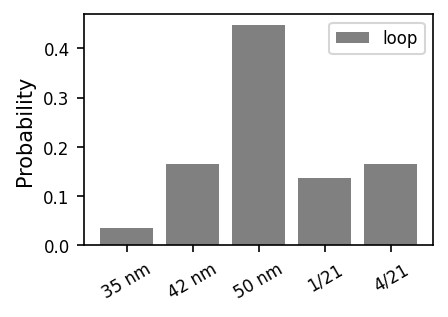

In [6]:
f, ax = plt.subplots(figsize=(3, 2))
for x, name in enumerate(main_names):
    #y1 = metrics[name]['linker']
    y2 = metrics[name]['loop']
    #y3 = 1 - (y1+y2)
    print(name, y2)
    ax.bar(x, y2, label='loop' if x == 0 else None, color='gray')
    #ax.bar(x, y1, label='linker' if x == 0 else None, color='black')
    #ax.bar(x, y3, bottom=y1+y2, label='domain', color='blue')
ax.legend()
ax.set_xticks(range(len(main_names)), main_names, rotation=30)
ax.set_ylabel('Probability')
plt.savefig('img/linker_prob_rc.pdf')
plt.show()

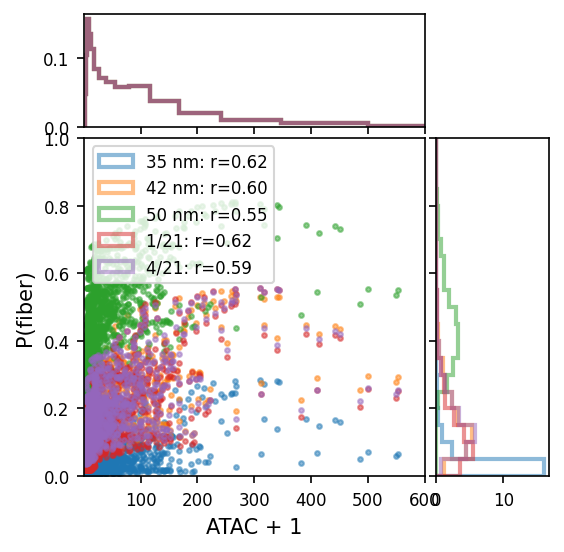

In [7]:
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr

f, ax = plt.subplots(2, 2, sharex='col', sharey='row', gridspec_kw={'height_ratios': [1, 3], 'width_ratios': [3, 1], 'wspace':0.05, 'hspace':0.05}, figsize=(4, 4))

buffer = 50_000 // 200
for name in main_names:
    region = prod[name]['mei'].mei.config['region']
    chrom, start, end = parse_region(region)

    atac = f'{omics}/genomics_data/GSE98390_E14_ATAC_MERGED.DANPOS.mm39.bw'
    atac = load_bw(atac, chrom, start, end)
    atac = bin_track(atac, step=200)
    atac = atac + 1

    p_loop = np.mean([d.labels == -1 for d in domains[name]], axis=0)

    bw = 2.5
    atac = gaussian_filter1d(atac, bw)
    p_loop = gaussian_filter1d(p_loop, bw)

    atac = atac[buffer:-buffer]
    p_loop = p_loop[buffer:-buffer]
    
    r, _ = pearsonr(np.log10(atac), p_loop)
    r, _ = pearsonr(atac, p_loop)

    ax[1, 0].scatter(atac, p_loop, alpha=0.5, s=5)
    ax[0, 0].hist(atac, bins=np.logspace(np.log10(1), np.log10(1500), 21), label=f'{name}: r={r:.2f}', alpha=0.5, histtype='step', density=False, weights=np.ones(len(atac))/len(atac), lw=2)
    ax[1, 1].hist(p_loop, bins=np.linspace(0, 1, 21), label=name, alpha=0.5, histtype='step', orientation='horizontal', density=True, lw=2)
    

handles, labels = ax[0, 0].get_legend_handles_labels()
ax[1, 0].legend(handles=handles, labels=labels, loc='upper left', fontsize=8)
ax[0, 1].axis('off')
ax[1, 0].set_ylabel('P(fiber)')
ax[1, 0].set_xlabel('ATAC + 1')
#ax[1, 0].set_xscale('log')
ax[1, 0].set_ylim(0, 1)
ax[1, 0].set_xlim(1, 600)
#plt.savefig('img/fiber_atac.pdf')
plt.show()

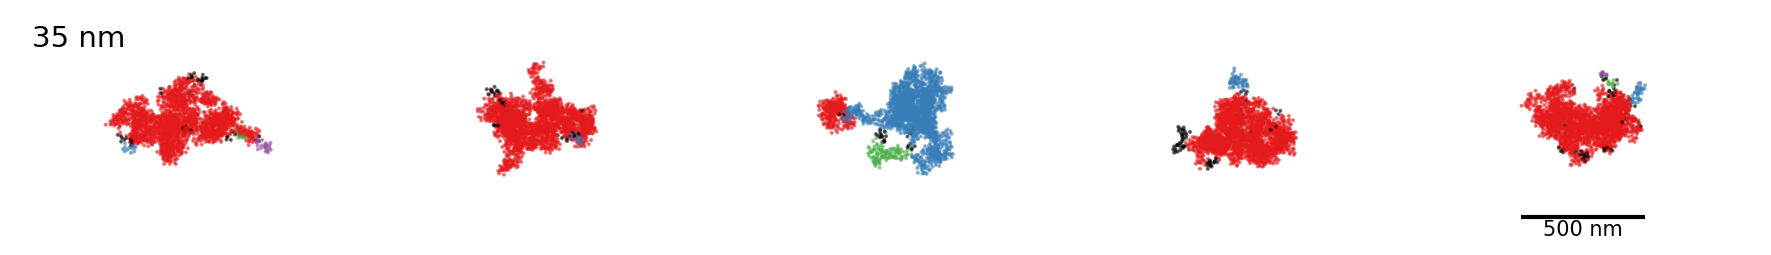

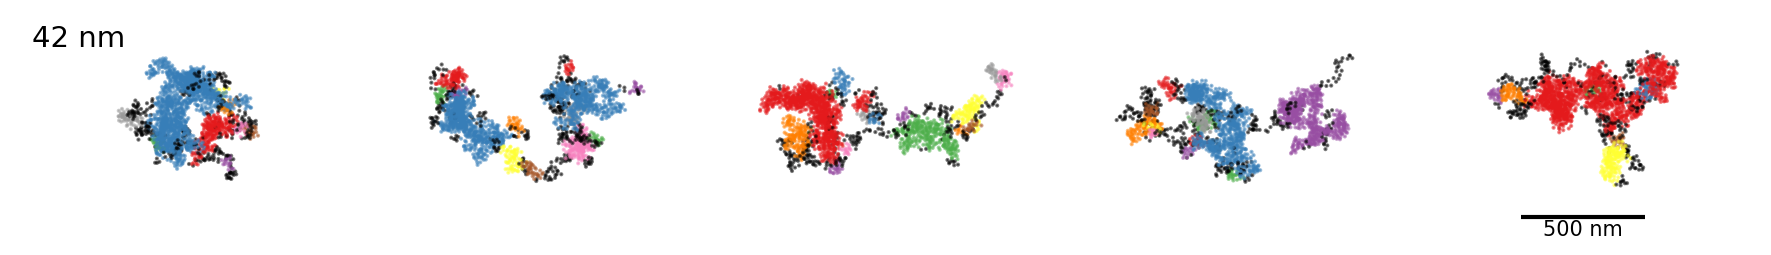

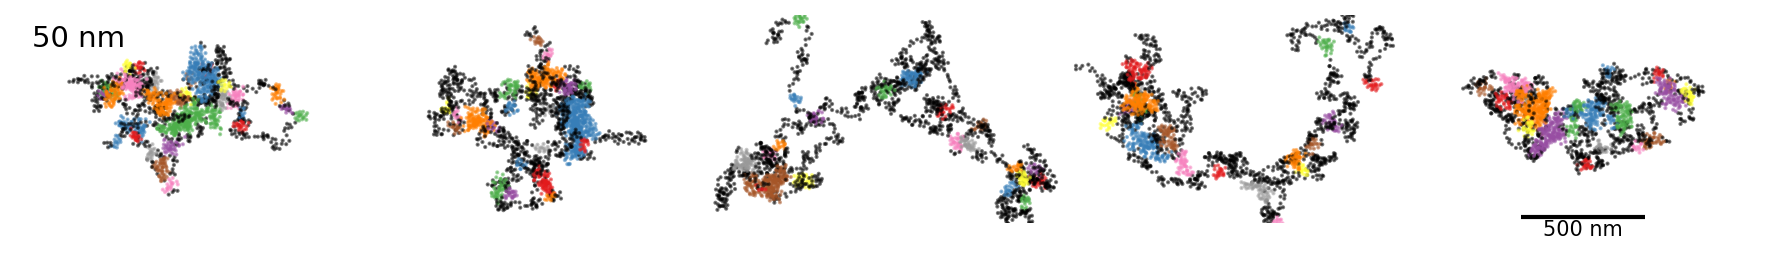

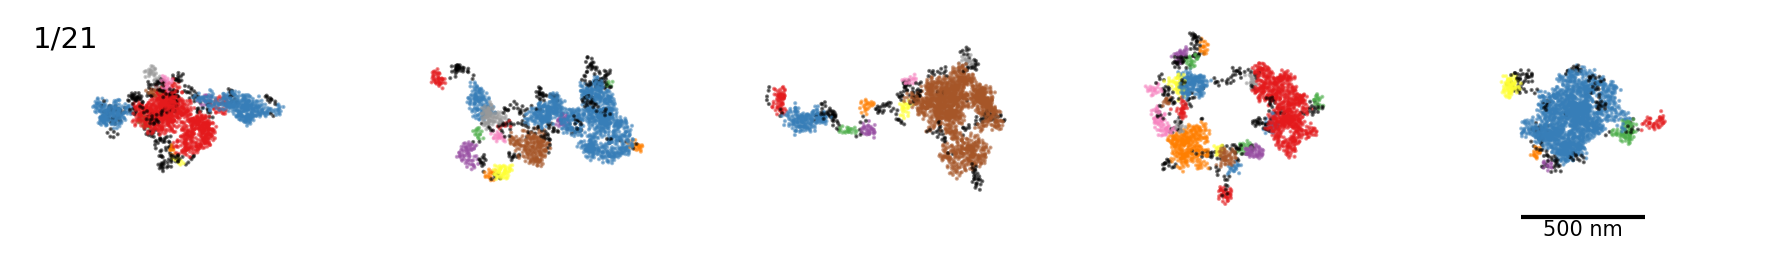

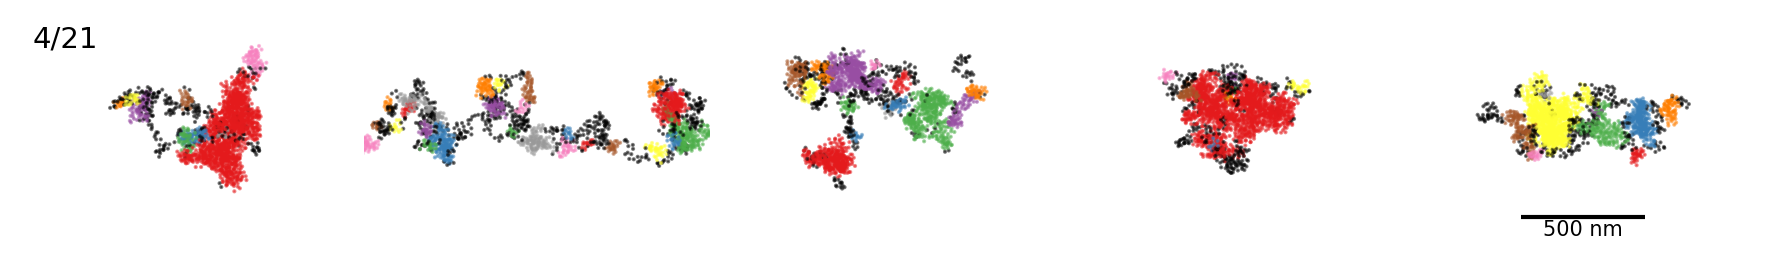

In [8]:
def plot_gallery_list(domains, func=lambda x, ax: x.plot_chain_2D(ax=ax, colorbar=False, s=1), size=500, rows=3, scalebar=500, fname=None):
    assert not len(domains) % rows
    cols = len(domains) // rows
    assert cols < 10

    aspect = 0.6
    size_h = size * aspect
    f, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(3*cols, 3*rows*aspect),
                         gridspec_kw=dict(hspace=0, wspace=0))

    axs = ax.flatten()
    
    for ax, domain in zip(axs, domains):
        func(domain, ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xlim(-size, size)
        ax.set_ylim(-size_h, size_h)
        ax.axis('off')

    axs[-1].plot([-scalebar/2, scalebar/2], [size_h/20-size_h, size_h/20-size_h], c='k', solid_capstyle="butt", lw=2)
    axs[-1].text(0, size_h/40-size_h, f'{scalebar} nm', va='top', ha='center')
    return f, axs

examples = 5
for name in main_names:
    dbscan = domains[name][::len(domains[name])//examples][:examples]
    
    f, axs = plot_gallery_list(dbscan, lambda x, ax: x.plot_2D(ax=ax, colorbar=False, s=1, alpha=0.5), scalebar=500, size=700, rows=1)
    axs[0].text(0.05, 0.95, name, va='top', ha='left', transform=axs[0].transAxes, size=14)
    plt.savefig(f'img/gallery_dbscan_{name.replace(" ", "_").replace("/", "_")}.pdf')
    plt.show()

35 nm


42 nm
50 nm
1/21
4/21


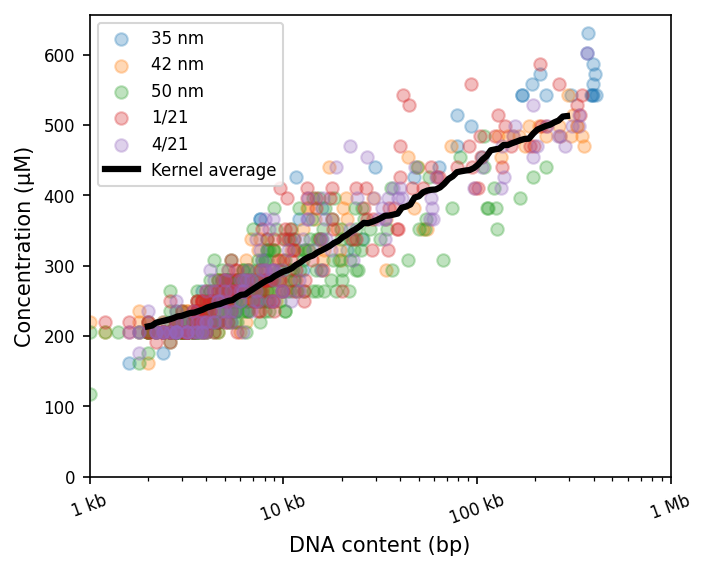

In [9]:
def kernel_average(x, y, bw, low=None, high=None, points=100):
    if low is None:
        low = np.min(x) + bw/2
    if high is None:
        high = np.max(x) - bw/2

    X = np.linspace(low, high, points)
    Y = np.zeros_like(X)
    for i, x_i in enumerate(X):
        mask = np.abs(x - x_i) < bw
        if np.sum(mask) == 0:
            continue
        Y[i] = np.mean(y[mask])
    return X, Y

def plot_concentration(domains, ds=10, breakpoint=50_000):
    f, ax = plt.subplot_mosaic([['concentration']], figsize=(5, 4))

    all_counts = []
    all_concs = []
    for name, _domains in domains.items():
        print(name)
        counts = []
        concs = []
        for domain in _domains[::ds]:
            conc = domain.get_concentrations(radius=30)
            for clutch in range(np.max(domain.labels)):
                indices = np.arange(domain.labels.shape[0])[domain.labels == clutch]
                size = len(indices) 

                counts += [200 *  size] # nucleosomes to bps
                concs += [np.max(conc[domain.labels == clutch])]
        counts = np.array(counts)
        concs = np.array(concs)
        all_counts.append(counts)
        all_concs.append(concs)

        ax['concentration'].scatter(counts, concs, label=name, alpha=0.3)

    all_counts = np.concatenate(all_counts)
    all_concs = np.concatenate(all_concs)

    X, Y = kernel_average(np.log10(all_counts), all_concs, bw=0.3, low=np.log10(2000))
    ax['concentration'].plot(10**X, Y, label='Kernel average', color='black', lw=3)


    ax['concentration'].set_ylabel('Concentration (µM)')
    ax['concentration'].set_ylim(0)

    for ax_name in ['concentration']:
        ax[ax_name].set_xlabel('DNA content (bp)')
        ax[ax_name].set_xscale('log')
        ax[ax_name].set_xticks([1e3, 1e4, 1e5, 1e6])
        ax[ax_name].set_xlim(1e3)
        format_ticks(ax[ax_name], y=False)
    return f, ax

_domains = {name: domains[name] for name in main_names if name in domains}
f, ax = plot_concentration(_domains, ds=100)
plt.legend()
plt.show()

/orcd/home/002/joepaggi/maxentnuc-private/maxentnuc/analysis/analysis.py:111: RuntimeWarning: divide by zero encountered in scalar divide
  conc = count / volume  # count / nm^3
/tmp/ipykernel_3207055/1274614369.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['radius'].set_yticklabels(tick_labels, minor=minor)
/tmp/ipykernel_3207055/1274614369.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['radius'].set_yticklabels(tick_labels, minor=minor)


Large fit: [4.38300954 0.34862011]
Small fit: [1.85608542 0.42697211]
[2.e+00 3.e+00 4.e+00 5.e+00 6.e+00 7.e+00 8.e+00 9.e+00 2.e+01 3.e+01
 4.e+01 5.e+01 6.e+01 7.e+01 8.e+01 9.e+01 2.e+02 3.e+02 4.e+02 5.e+02
 6.e+02 7.e+02 8.e+02 9.e+02 2.e+03 3.e+03 4.e+03 5.e+03 6.e+03 7.e+03
 8.e+03 9.e+03 2.e+04 3.e+04 4.e+04 5.e+04 6.e+04 7.e+04 8.e+04 9.e+04]
[1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]


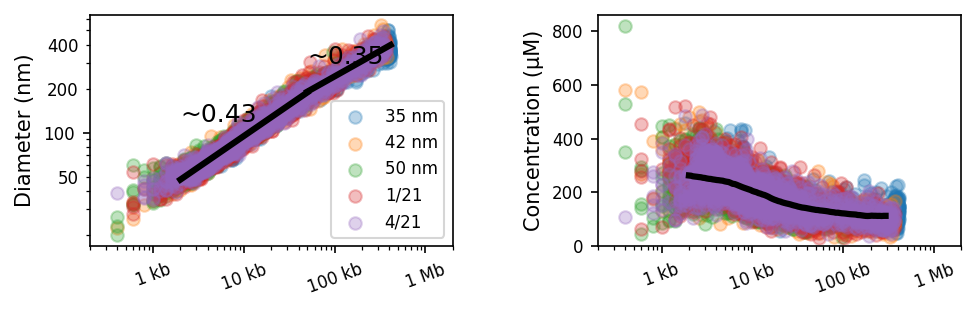

Large fit: [4.75974874 0.32132387]
Small fit: [3.68602513 0.34414229]
[2.e+00 3.e+00 4.e+00 5.e+00 6.e+00 7.e+00 8.e+00 9.e+00 2.e+01 3.e+01
 4.e+01 5.e+01 6.e+01 7.e+01 8.e+01 9.e+01 2.e+02 3.e+02 4.e+02 5.e+02
 6.e+02 7.e+02 8.e+02 9.e+02 2.e+03 3.e+03 4.e+03 5.e+03 6.e+03 7.e+03
 8.e+03 9.e+03 2.e+04 3.e+04 4.e+04 5.e+04 6.e+04 7.e+04 8.e+04 9.e+04]
[1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]


/tmp/ipykernel_3207055/1274614369.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['radius'].set_yticklabels(tick_labels, minor=minor)
/tmp/ipykernel_3207055/1274614369.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['radius'].set_yticklabels(tick_labels, minor=minor)


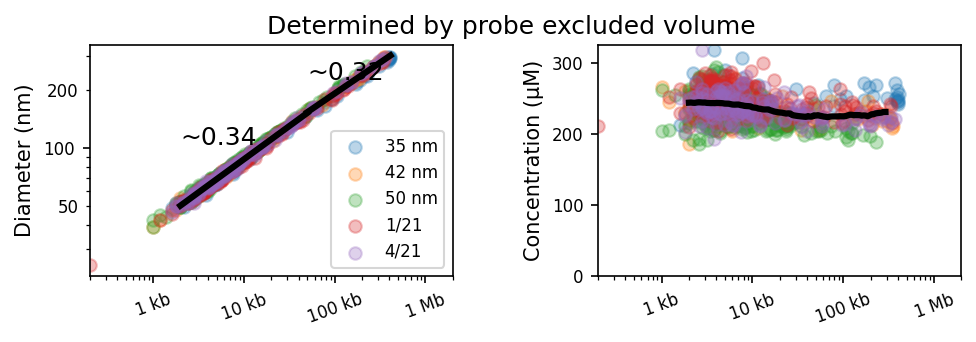

In [10]:
def plot_scaling(domains, volume_func, ds=10, breakpoint=50_000):
    f, ax = plt.subplot_mosaic([['radius', 'concentration']], figsize=(7.5, 2), gridspec_kw={'wspace': 0.4})

    all_diameters = []
    all_counts = []
    all_concs = []
    for name, _domains in domains.items():
        diameters = []
        counts = []
        concs = []
        for domain in _domains[::ds]:
            for clutch in range(np.max(domain.labels)):
                indices = np.arange(domain.labels.shape[0])[domain.labels == clutch]
                size = len(indices) 
                points = domain.positions[indices]
                volume = volume_func(points)
                radius = (volume / (4/3 * np.pi)) ** (1/3)

                diameters += [2 * radius]
                counts += [200 *  size] # nucleosomes to bps
                concs += [to_micromolar(size, volume)]
        counts = np.array(counts)
        diameters = np.array(diameters)
        concs = np.array(concs)
        all_diameters.append(diameters)
        all_counts.append(counts)
        all_concs.append(concs)

        ax['radius'].scatter(counts, diameters, label=name, alpha=0.3)
        ax['concentration'].scatter(counts, concs, label=name, alpha=0.3)

    all_diameters = np.concatenate(all_diameters)
    all_counts = np.concatenate(all_counts)
    all_concs = np.concatenate(all_concs)

    X, Y = kernel_average(np.log10(all_counts), all_concs, bw=0.3, low=np.log10(2000))
    ax['concentration'].plot(10**X, Y, label='Kernel average', color='black', lw=3)

    if breakpoint is None:
        mask = ~np.isnan(all_diameters)
        popt, _ = curve_fit(power_law, all_counts[mask], all_diameters[mask])
        x = np.linspace(2000, np.max(all_counts))
        print('Fit:', popt)
        ax['radius'].plot(x, power_law(x, *popt),  color='black', lw=3)
        ax['radius'].text(x[0], power_law(x[len(x)//4], *popt), f'~{popt[1]:.2f}',
                        color='black', fontsize=12, ha='left', va='bottom')
    else:
        mask = ~np.isnan(all_diameters) & (all_counts > breakpoint)
        popt, _ = curve_fit(power_law, all_counts[mask], all_diameters[mask])
        x = np.linspace(breakpoint, np.max(all_counts))
        print('Large fit:', popt)
        ax['radius'].plot(x, power_law(x, *popt),  color='black', lw=3)
        ax['radius'].text(x[0], power_law(x[len(x)//4], *popt), f'~{popt[1]:.2f}',
                        color='black', fontsize=12, ha='left', va='bottom')

        mask = ~np.isnan(all_diameters) & (all_counts < breakpoint)
        popt, _ = curve_fit(power_law, all_counts[mask], all_diameters[mask])
        x = np.linspace(2_000, breakpoint)
        print('Small fit:', popt)
        ax['radius'].plot(x, power_law(x, *popt), color='black', lw=3)
        ax['radius'].text(x[0], power_law(x[len(x)//4], *popt), f'~{popt[1]:.2f}',
                        color='black', fontsize=12, ha='left', va='bottom')

    ax['radius'].set_ylabel('Diameter (nm)')
    ax['radius'].legend(fontsize=8)
    ax['radius'].set_yscale('log')

    ax['concentration'].set_ylabel('Concentration (µM)')
    ax['concentration'].set_ylim(0)

    for ax_name in ['radius', 'concentration']:
        #ax[ax_name].set_xlabel('DNA content (bp)')
        ax[ax_name].set_xscale('log')
        ax[ax_name].set_xticks([1e3, 1e4, 1e5, 1e6])
        ax[ax_name].set_xlim(200, 2_000_000)
        format_ticks(ax[ax_name], y=False)

    custom_values = [50, 100, 200, 400]
    for minor in [True, False]:
        yticks = ax['radius'].get_yticks(minor=minor)
        print(yticks)
        tick_labels = [f"{int(t)}" if t in custom_values else "" for t in yticks]
        ax['radius'].set_yticklabels(tick_labels, minor=minor)
    format_ticks(ax['radius'], y=False)
    return f, ax


def get_rg_volume(points):
    # Rg^2 = 3/5 R^2 -> R^3 = (5/3)^(3/2)Rg^3
    return 4/3*np.pi * (5/3)**(3/2) * np.sqrt(np.sum((points - points.mean(axis=0, keepdims=True))**2)  / len(points))**3

_domains = {name: domains[name] for name in main_names if name in domains}
plot_scaling(_domains, get_rg_volume)
#plt.savefig('img/packing_domain_scaling_rg.pdf')
plt.show()

from maxentnuc.analysis.domain_analyzer import get_volume
plot_scaling(_domains, lambda x: get_volume(x, probe_radius=20, particle_radius=12, grid_resolution=5), ds=100)
plt.suptitle(r'Determined by probe excluded volume')
plt.show()

35 nm 15400
35 nm 419000
42 nm 28800


42 nm 385600
50 nm 76200
50 nm 307200
1/21 26800
1/21 391800
4/21 32800
4/21 382400


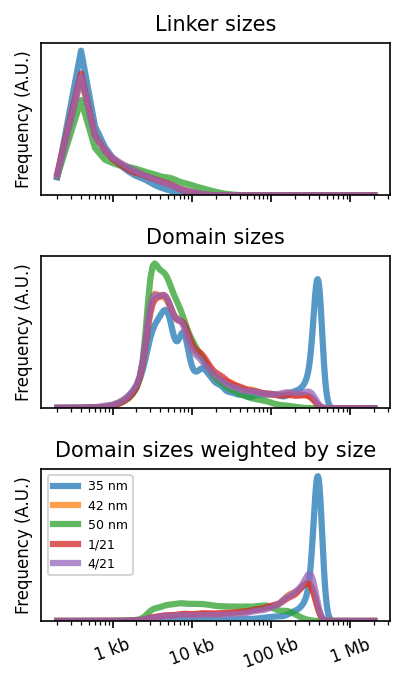

In [11]:
from scipy.stats import gaussian_kde


def myhist(data, bins, ax=None, density=True, bw = 0.05, alpha=0.75, lw=3, n_points=1000, weights=None, **kwargs):
    p = plt if ax is None else ax
    if data.min() < bins[0] or data.max() > bins[-1]:
        print(f'Warning: data outside range ({data.min()} to {data.max()} vs {bins[0]} to {bins[-1]})')
    
    cov = np.cov(np.log10(data), aweights=weights if weights is not None else None)
    kde = gaussian_kde(np.log10(data), weights=weights, bw_method=bw / cov**0.5)

    x = np.arange(1, 500) * 200 # plot every 200 bp from 200 to 100 kb
    x = np.concatenate([x, np.logspace(np.log10(x[-1]), np.log10(bins[-1]), n_points)])
    y = kde(np.log10(x))
    p.plot(x, y, lw=lw, alpha=alpha, **kwargs)

for name_filter, plot_fname in [(lambda x: name in main_names, 'img/domain_sizes_rc.pdf')]:
    bins = np.logspace(np.log10(199), np.log10(2_000_000), 21)
    f, axs = plt.subplots(3, sharex=True, figsize=(3, 5), gridspec_kw={'hspace': 0.4})
    for name, domain in domains.items():
        if not name_filter(name):
            continue

        # Linkers.
        linkers = [Domains(d.positions.copy(), get_segments(d.labels == -1)) for d in domain]
        w = np.array([np.sum(_domain.labels==i) for _domain in linkers for i in range(_domain.n_clusters)])
        w *= 200
        print(name, np.max(w))
        myhist(w, bins=bins, label=name, ax=axs[0], weights=np.zeros(w.shape) + 1 / len(w), density=False)

        # Domains
        w = np.array([np.sum(_domain.labels==i) for _domain in domain for i in range(_domain.n_clusters)])
        w *= 200
        print(name, np.max(w))
        myhist(w, bins=bins, label=name, ax=axs[1], weights=np.zeros(w.shape) + 1 / len(w), density=False)
        myhist(w, bins=bins, label=name, ax=axs[2], weights=w/sum(w), density=False)

    axs[0].set_title('Linker sizes', fontsize=10)
    axs[1].set_title('Domain sizes', fontsize=10)
    axs[2].set_title('Domain sizes weighted by size', fontsize=10)
    
    axs[1].set_xscale('log')
    for ax in axs:
        ax.set_ylabel('Frequency (A.U.)', fontsize=8)

    axs[2].legend(fontsize=6)
    for ax in axs:
        ax.set_yticks([])
        ax.set_ylim(0)
        format_ticks(ax, y=False)
    plt.savefig(plot_fname)
    plt.show()